In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [15]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q '/content/drive/My Drive/MTDDH.zip' -d '/content/mtddh'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/mtddh/MTDDH/Dataset1/Keypoints/Keypoints_Train.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
def generate_target_heatmaps(keypoints, img_size=(256, 256), sigma=3):
    w, h = img_size
    num_kps = len(keypoints)
    target = torch.zeros((num_kps, h, w))

    x = torch.arange(w, dtype=torch.float32)
    y = torch.arange(h, dtype=torch.float32)
    y_grid, x_grid = torch.meshgrid(y, x, indexing='ij')

    for i in range(num_kps):
        x_coord, y_coord = keypoints[i]

        if x_coord <= 0 or y_coord <= 0:
            continue

        dist_sq = (x_grid - x_coord)**2 + (y_grid - y_coord)**2

        heatmap = torch.exp(-dist_sq / (2 * sigma**2))

        if heatmap.max() > 0:
            heatmap = heatmap / heatmap.max()

        target[i] = heatmap

    return target

In [5]:
def get_coords_from_heatmap(heatmap_volume):
  coord = []

  for i in range(heatmap_volume.shape[0]):
      single_map = heatmap_volume[i]

      y, x = (single_map == torch.max(single_map)).nonzero()[0]

      coord.append([x.item(), y.item()])
  return np.array(coord)

In [6]:
class MTDDHDataset(Dataset):
  def __init__(self, root_dir, split ='Train', image_size = 256):
      self.image_size = image_size
      self.entries = []

      json_path = os.path.join(root_dir, 'Keypoints', f"Keypoints_{split}.json")
      img_dir = os.path.join(root_dir, 'Keypoints', split)
      with open(json_path, 'r') as f:
          data = json.load(f)
      img_by_id = {img['id']: img for img in data['images']}
      for ann in data['annotations']:
          img_id = ann['image_id']
          file_name = img_by_id[img_id]['file_name']
          kps_flat = np.array(ann['keypoints'])
          kps = kps_flat.reshape(-1, 3)[:, :2]
          self.entries.append({
              'image_path': os.path.join(img_dir, file_name),
              'keypoints': kps
          })

          self.transforms = transforms.Compose([
              transforms.Resize((image_size, image_size)),
              transforms.ToTensor(),
              transforms.Normalize(mean = [0.5], std = [0.5,0.5,0.5]),

          ])

  def __len__(self):
      return len(self.entries)

  def __getitem__(self, idx):
      entry = self.entries[idx]

      img=  Image.open(entry['image_path']).convert("RGB")
      W_orig, H_orig = img.size
      img_t = self.transforms(img)
      scale_x = self.image_size/ W_orig
      scale_y = self.image_size/ H_orig
      kps_resized = entry['keypoints']*np.array([scale_x, scale_y])

      target_maps = generate_target_heatmaps(kps_resized, (self.image_size, self.image_size))

      return img_t, target_maps

In [7]:
class ResnetHM(nn.Module):
    def __init__(self, num_keypoints= 8):
        super(ResnetHM, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(16, num_keypoints, 1)
        )

    def forward(self, x):
      x =  self.encoder(x)
      x = self.decoder(x)
      return x

In [8]:
root_kp = '/content/mtddh/MTDDH/Dataset1/Keypoints'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
train_dataset = MTDDHDataset(root_dir = os.path.dirname(root_kp), split = 'Train', image_size = 256)
train_dataloader = DataLoader( train_dataset, batch_size=  8, shuffle = True)
val_dataset = MTDDHDataset(root_dir = os.path.dirname(root_kp), split = 'Validation', image_size = 256)
val_dataloader = DataLoader( val_dataset, batch_size=  8)

In [10]:
!ls /content/mtddh/MTDDH/Dataset1/Keypoints

Keypoints_Train.json  Keypoints_Validation.json  Test  Train  Validation


In [11]:
os.path.dirname(root_kp)

'/content/mtddh/MTDDH/Dataset1'

In [12]:
model = ResnetHM(num_keypoints= 8).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [13]:
from pygments.formatters import img
import torch.cuda.amp as amp # Import amp

scaler = amp.GradScaler() # Initialize GradScaler

for epoch in range(20):
    model.train()
    epoch_loss = 0

    for i, (img, targets) in enumerate(train_dataloader):
        img = img.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        with amp.autocast(): # Use autocast for mixed precision
            pred = model(img)
            loss = criterion(pred, targets)

        scaler.scale(loss).backward() # Scale loss and perform backward pass
        scaler.step(optimizer) # Update optimizer weights
        scaler.update() # Update the scaler for the next iteration

        epoch_loss += loss.item()

        if i%10 == 0:
          print( f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")
    print(f"Epoch: {epoch}, Loss: {epoch_loss/len(train_dataloader)}")

/tmp/ipython-input-497386958.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler() # Initialize GradScaler
/tmp/ipython-input-497386958.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Use autocast for mixed precision


Epoch: 0, Batch: 0, Loss: 0.023441258817911148
Epoch: 0, Batch: 10, Loss: 0.007020394317805767
Epoch: 0, Batch: 20, Loss: 0.001756390556693077
Epoch: 0, Batch: 30, Loss: 0.0009347932646051049
Epoch: 0, Batch: 40, Loss: 0.0007261206628754735
Epoch: 0, Batch: 50, Loss: 0.0006170034175738692
Epoch: 0, Batch: 60, Loss: 0.0005584852187894285
Epoch: 0, Batch: 70, Loss: 0.0005226648063398898
Epoch: 0, Batch: 80, Loss: 0.0004986401181668043
Epoch: 0, Batch: 90, Loss: 0.0004850396071560681
Epoch: 0, Loss: 0.0025806160532627063
Epoch: 1, Batch: 0, Loss: 0.0004820245667360723
Epoch: 1, Batch: 10, Loss: 0.0004781701718457043
Epoch: 1, Batch: 20, Loss: 0.0004705354804173112
Epoch: 1, Batch: 30, Loss: 0.00046446092892438173
Epoch: 1, Batch: 40, Loss: 0.0004604663117788732
Epoch: 1, Batch: 50, Loss: 0.00045619180309586227
Epoch: 1, Batch: 60, Loss: 0.0004534792678896338
Epoch: 1, Batch: 70, Loss: 0.0004504449316300452
Epoch: 1, Batch: 80, Loss: 0.00044932219316251576
Epoch: 1, Batch: 90, Loss: 0.0004

--- Error Report for Image #0 ---


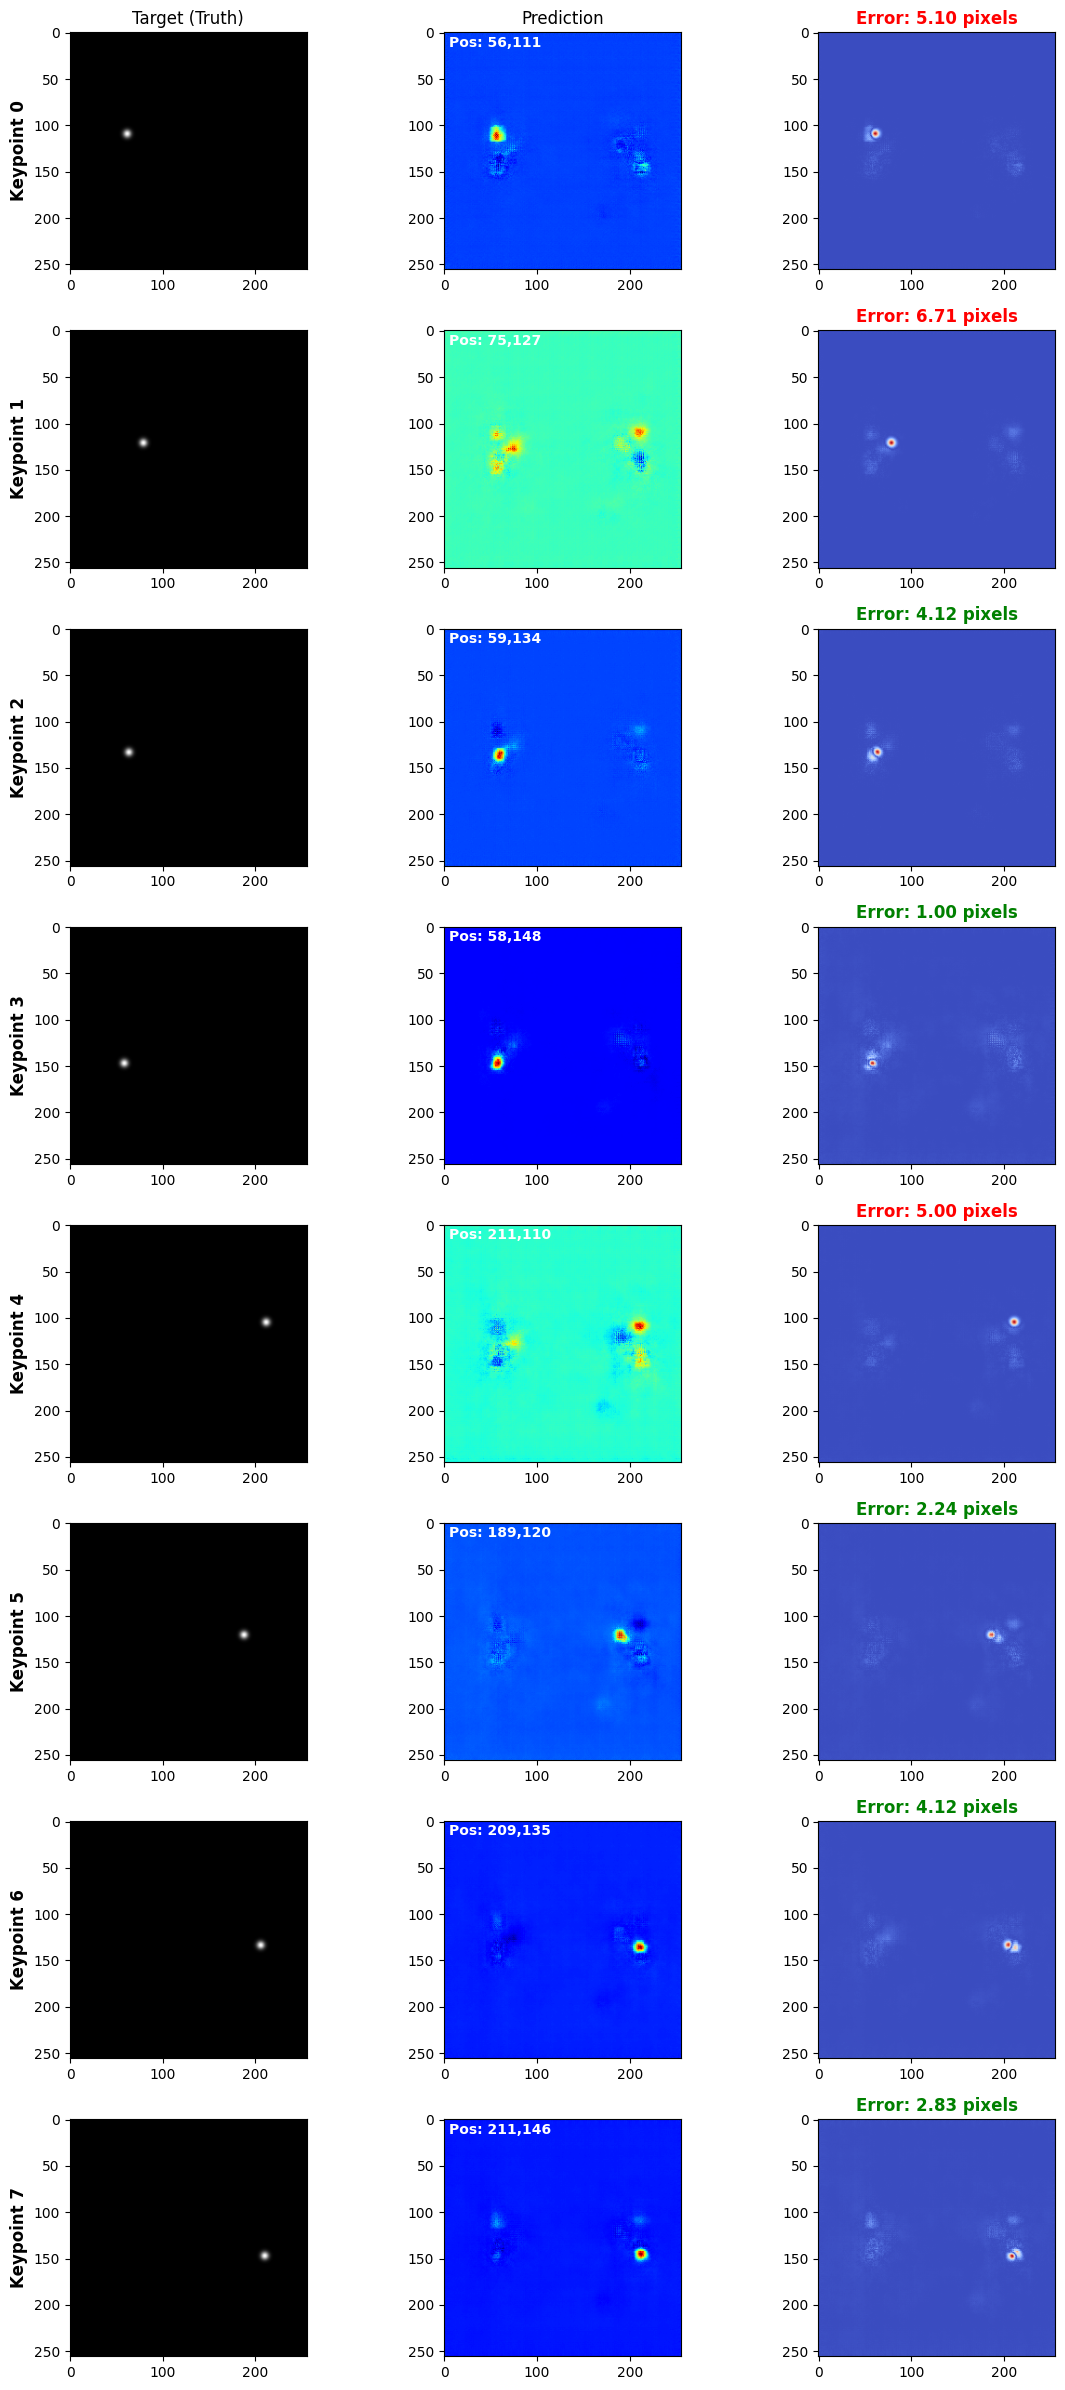

In [14]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def get_max_preds(batch_heatmaps):

    batch_size, num_keypoints, h, w = batch_heatmaps.shape
    heatmaps_reshaped = batch_heatmaps.view(batch_size, num_keypoints, -1)

    idx = torch.argmax(heatmaps_reshaped, 2)

    maxvals, _ = torch.max(heatmaps_reshaped, 2)
    preds = torch.zeros((batch_size, num_keypoints, 2)).to(batch_heatmaps.device)

    preds[:, :, 0] = idx % w  # X coordinate
    preds[:, :, 1] = idx // w # Y coordinate

    return preds

def visualize_with_distance(model, dataloader, device):
    model.eval()

    images, targets = next(iter(dataloader))
    images = images.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        preds = model(images)

    pred_coords = get_max_preds(preds)
    target_coords = get_max_preds(targets)

    distances = torch.norm(pred_coords - target_coords, dim=2)

    img_idx = 0
    num_keypoints = 8

    fig, axes = plt.subplots(nrows=num_keypoints, ncols=3, figsize=(12, 24))

    print(f"--- Error Report for Image #{img_idx} ---")

    for i in range(num_keypoints):

        pixel_error = distances[img_idx, i].item()

        axes[i, 0].imshow(targets[img_idx, i].cpu().numpy(), cmap='gray')
        axes[i, 0].set_ylabel(f'Keypoint {i}', fontsize=12, fontweight='bold')
        if i == 0: axes[i, 0].set_title("Target (Truth)")

        axes[i, 1].imshow(preds[img_idx, i].cpu().numpy(), cmap='jet')
        if i == 0: axes[i, 1].set_title("Prediction")

        pred_x = int(pred_coords[img_idx, i, 0])
        pred_y = int(pred_coords[img_idx, i, 1])
        axes[i, 1].text(5, 15, f"Pos: {pred_x},{pred_y}", color='white', fontweight='bold')

        diff = torch.abs(preds - targets)
        axes[i, 2].imshow(diff[img_idx, i].cpu().numpy(), cmap='coolwarm')

        color = 'green' if pixel_error < 5.0 else 'red'
        axes[i, 2].set_title(f"Error: {pixel_error:.2f} pixels", color=color, fontweight='bold')

    plt.tight_layout()
    plt.show()
visualize_with_distance(model, val_dataloader, device)

In [16]:
torch.save(model.state_dict(), 'resnet_heatmap_model.pth')
print("Model saved successfully to resnet_heatmap_model.pth")

Model saved successfully to resnet_heatmap_model.pth
